# Calculate angular Cl's with CCL
In this example, we will calculate the lensing angular power spectrum for an example cosmology.

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl

### Set up a Cosmology object
`Cosmology` objects contain the parameters and metadata needed as inputs to most functions. In `pyccl`, you can create one by first creating a new `Parameters` object, which simply contains the values of cosmological parameters (including some derived parameters). In this example, we define the parameters of a vanilla LCDM model, but simple extensions (like curvature, neutrino mass, and w0/wa) are also supported.

`Cosmology` objects contain precomputed data (e.g. splines) to help speed-up certain calculations. As such, `Cosmology` objects are supposed to be immutable; you should create a new `Cosmology` object when you want to change the values of any cosmological parameters.

In [2]:
p = ccl.Parameters(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
cosmo = ccl.Cosmology(p)

In [3]:
print p

Parameters
----------
        Omega_c: 0.27
        Omega_b: 0.045
        Omega_m: 0.315
        Omega_n: 0.0
        Omega_k: 0.0
             w0: -1.0
             wa: 0.0
             H0: 67.0
              h: 0.67
            A_s: 2.1e-09
            n_s: 0.96
        Omega_g: 5.50353082768e-05
          T_CMB: 2.725
        sigma_8: nan
        Omega_l: 0.684944964692
         z_star: nan
    has_mgrowth: False


As you can see, a number of cosmological parameters have been set to default values, or derived from the input parameters. Some, like `sigma_8`, have been left undefined; this is because calculating them from the input parameters is non-trivial, so this will only be done if needed (or if the user explicitly requests it).

Parameter values can be accessed from the Parameters object like so:

In [4]:
print p['Omega_c']
print cosmo

0.27
Parameters
----------
        Omega_c: 0.27
        Omega_b: 0.045
        Omega_m: 0.315
        Omega_n: 0.0
        Omega_k: 0.0
             w0: -1.0
             wa: 0.0
             H0: 67.0
              h: 0.67
            A_s: 2.1e-09
            n_s: 0.96
        Omega_g: 5.50353082768e-05
          T_CMB: 2.725
        sigma_8: nan
        Omega_l: 0.684944964692
         z_star: nan
    has_mgrowth: False

Precomputed data
----------------
  has_distances: False
     has_growth: False
      has_power: False
      has_sigma: False

Status
------
status(0): 


We could have also created a `Cosmology` object directly, without creating a `Parameters` object first:

In [5]:
cosmo2 = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
print cosmo2.params['H0']

67.0


### Define a source number density
The angular power spectrum is weighted by the source number density as a function of redshift, dN/dz. We define an example here.

In [6]:
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

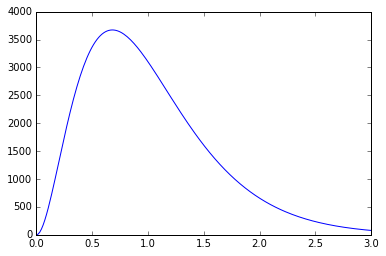

In [7]:
plt.plot(z, dNdz)
plt.show()

### Create ClTracer objects
CCL manages auto- and cross-spectrum calculations through `ClTracer` objects. For the sake of this example we will define two separate tracers, but both will effectively be the same tracer (so we end up calculating the auto-spectrum).

In [8]:
lens1 = ccl.ClTracerLensing(cosmo, False, z=z, n=dNdz)
lens2 = ccl.ClTracerLensing(cosmo, False, n=(z, dNdz))

The argument set to `False` in these statements specifies that we are ignoring intrinsic alignments.

Note how there are two different ways of specifying the number density, `dNdz`. The first one specifies the `z` and `dNdz` arrays as separate arguments. This is useful if you need to specify several redshift functions that are gridded onto the _same_ `z` array. For example, if we wanted to include intrinsic alignments, we could have created the `ClTracer` object like so:

In [9]:
bias_ia = np.ones(z.size) # Intrinsic alignment bias factor
f_red = 0.5 * np.ones(z.size) # Fraction of red galaxies
lens1_ia = ccl.ClTracerLensing(cosmo, True, z=z, n=dNdz, bias_ia=bias_ia, f_red=f_red)

The redshift functions are often binned quite differently, so sharing the same `z` array doesn't make sense. Instead, you can specify each function as a tuple, of the form `(z_array, function_array)`. Each pair can be binned in redshift however you like, e.g.

In [10]:
z_ia = np.linspace(0., 3., 5) # Only 5 redshift bins
bias_ia2 = np.ones(z_ia.size)
lens2_ia = ccl.ClTracerLensing(cosmo, True, n=(z, dNdz), bias_ia=(z_ia, bias_ia), f_red=(z, f_red))

### Calculate the angular power spectrum
We can now calculate the angular power spectrum for the tracer(s). Internally, the calculation will be performed up to some $\ell_{\rm max}$, which will be relatively slow when first run. If we call the `angular_cl` function again with a different $\ell$ sampling, it will be quickly evaluated from a spline though.

In [11]:
ell = np.arange(2, 100)
cls = ccl.angular_cl(cosmo, lens1, lens2, ell)

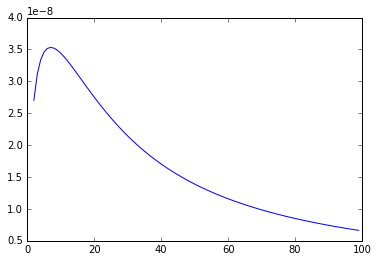

In [12]:
plt.plot(ell, cls)
plt.show()